# Chapter 19: Space Invaders with Double Deep Q Learning

In Chapter 18, you learned how to use a double deep Q network to train the agent in the Breakout game to send the ball to the back of the wall to score more efficiently. The trained agent is able to eliminate almost all bricks on the screen. 

In this chapter, you'll apply the double deep Q learning to another Atari game, Space Invaders. You'll learn the features of the game that are different from the Breakout game so that you know how to tweak the training process. 

You then feed the raw pixels to the double deep Q network to train the agent. Even though the agent does not know the rules of the Space Invaders game, it has managed to eliminate all invaders on the screen, just by learning from the reward system via repeated interactions with the game environment. 

At the end of the chapter, you'll learn how to capture an episode of the game in which the trained agent eliminates all invaders. You'll also learn how to enhance the quality of the graphs so that the animation has four times the resolution as the original OpenAI Gym videos. The animation is below (notice the high resolution):<br>


<img src="https://gattonweb.uky.edu/faculty/lium/ml/spaceinvaders_enhanced.gif" />

***
$\mathbf{\text{Create a subfolder for files in Chapter 19}}$<br>
***
We'll put all files in Chapter 19 in a subfolder /files/ch19. The code in the cell below will create the subfolder.

***

In [1]:
import os

os.makedirs("files/ch19", exist_ok=True)

## 1. Get Started with the Space Invaders Game

In this section, you'll learn how to play the Space Invaders game, both with and without the help from the baselines package. I'll focus on the features that are important in terms of training game strategies.

### 1.1. The Space Invaders Game in OpenAI Gym

You'll first learn to play the Space Invaders game in OpenAI Gym.

The lines of code below will get you started.

In [1]:
import gym
env = gym.make("SpaceInvaders-v0")
env.reset()
env.render()

True

You should see a Space Invaders game frame in a separate window. 

You can check the action space and observation space of the game as follows:

In [4]:
# Print out all possible actions in this game
actions = env.action_space
print(f"The action space for the Space Invaders game is {actions}")
meanings = env.env.get_action_meanings()
print(f"The meanings of the actions for the Space Invaders game are\n {meanings}")

# Print out the observation space in this game
obs_space = env.observation_space
print(f"The observation space for the Space Invaders game is {obs_space}")

The action space for the Space Invaders game is Discrete(6)
The meanings of the actions for the Space Invaders game are
 ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
The observation space for the Space Invaders game is Box(210, 160, 3)


There are six possible actions the agent can take: 
* action 0: doing nothing
* action 1: firing bullets
* action 2: moving to the right
* action 3: moving to the left
* action 4: moving to the right and firing bullets
* action 5: moving to the left and firing bullets

Each observation is a color picture that is 210 pixels tall and 160 pixels wide. The following cell displays an observation.

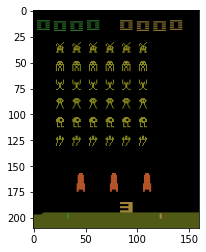

In [7]:
import matplotlib.pyplot as plt
import numpy as np

num_actions = env.action_space.n

env.reset()

for _ in range(20):
    action = np.random.choice(num_actions)
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()
env.close()

The number of lives left is displayed at the bottom and the scores are displayed at the top.

Next, you'll print out the outputs of the game to understand the reward system.

In [14]:
import gym
from pprint import pprint
env = gym.make("SpaceInvaders-v0")
env.reset()
env.render()

history = []
while True:
    action = np.random.choice(num_actions)
    obs, reward, done, info = env.step(action)
    env.render()
    history.append([reward, done, info])
    if info["ale.lives"]==2:
        pprint(history[-10:])
        break
env.close()        

[[0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 2}]]


The agent has three lives in this game. When one life is lost, the reward is still 0, not -1 as in the Pong game. Further, the variable *done* is still False after a life is lost. The variable *done* turns True only after all three lives are lost.

Therefore, we need the help of the baselines package to break an episode into smaller episodes. 

### 1.2. The Space Invaders Game with the OpenAI Baselines

With the baselines game wrapper, the agent has one life in each episode. That is, each time the agent loses a life, the episode ends and the variable done turns True. This makes reconfiguring the reward system much easier. Each time the game ends (i.e., done==True), we set the Q-value to -1. This is crucial for the success of the training. 

Let's make sure that's indeed the case. Run the code in the cell below.

In [16]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

# Use the Baseline Atari environment
env = make_atari("SpaceInvadersNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

obs = env.reset()
history = []
while True:
    # randomly pick actions
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    history.append([action, reward, done, info])
    # Render the env
    env.render()
    if done:
        pprint(history[-10:])
        break
       

[[1, 0.0, False, {'ale.lives': 3}],
 [3, 0.0, False, {'ale.lives': 3}],
 [4, 0.0, False, {'ale.lives': 3}],
 [1, 0.0, False, {'ale.lives': 3}],
 [5, 0.0, False, {'ale.lives': 3}],
 [1, 0.0, False, {'ale.lives': 3}],
 [2, 0.0, False, {'ale.lives': 3}],
 [1, 0.0, False, {'ale.lives': 3}],
 [5, 0.0, False, {'ale.lives': 3}],
 [1, 0.0, True, {'ale.lives': 2}]]


As you can see, when the number of lives changes from 3 to 2, the variable done becomes True and the episode ends. Note that the reward is still 0, but we can code it as -1 by using this line of code; you'll see it in the script for training later:

```python
    # Each time the agent loses a life, set Q to -1; important
    new_Qs = Qs * (1 - dones) - dones
```

Run the following to close the game window.

In [17]:
env.close()

### 1.3. Preprocessed Frames from the OpenAI Baselines

The baselines game wrapper preprocesses the game images for you. In every time step, it returns four consecutive frames of preprocessed images, each with a size of 84 by 84.  

Let's visualize the preprocessed images from the baseline package. Run the code in the cell below.

Exception ignored in: <function SimpleImageViewer.__del__ at 0x0000016179E28E50>
Traceback (most recent call last):
  File "C:\Users\hlliu2\Anaconda3\envs\animatedML\lib\site-packages\gym\envs\classic_control\rendering.py", line 369, in __del__
    self.close()
  File "C:\Users\hlliu2\Anaconda3\envs\animatedML\lib\site-packages\gym\envs\classic_control\rendering.py", line 365, in close
    self.window.close()
  File "C:\Users\hlliu2\Anaconda3\envs\animatedML\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\hlliu2\Anaconda3\envs\animatedML\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\hlliu2\Anaconda3\envs\animatedML\lib\_weakrefset.py", line 114, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x00000161037F4040; to 'Win32Window' at 0x00000161037C4A90>


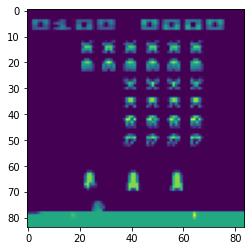

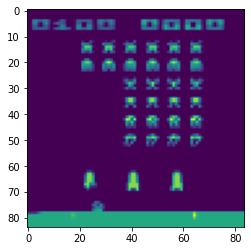

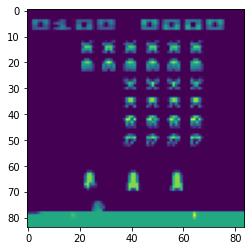

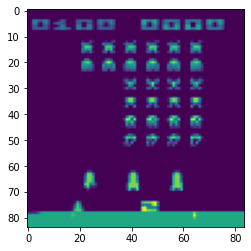

In [18]:
import matplotlib.pyplot as plt
import numpy as np

npobs=np.array(obs)
for i in range(4):
    plt.imshow(npobs[:,:,i])
    plt.show()

You can see the four consecutive frames. 

## 2. Use the Double Deep Q Network to Train the Agent
We can use the same Double Deep Q Network in Chapter 18 to train the Space Invaders game. The only thing we need to change is the number of actions. In the Breakout game, the number of actions is 4. In the Space Invaders game, the number of actions is 6. So we need to change it accordingly.

We'll use the same script we used in Chapter 18, which in turn is largely based on the example script by Jacob Chapman and Mathias Lechner https://keras.io/examples/rl/deep_q_network_breakout/. 

In [ ]:
import random
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from baselines.common.atari_wrappers import make_atari
from baselines.common.atari_wrappers import wrap_deepmind

# Use the Baseline Atari environment
env = make_atari("SpaceInvadersNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

# Discount factor for past rewards
gamma = 0.99 
# batch size
batch_size = 32  

# The number of actions in Space Invaders is 6
num_actions = 6

# The same double Q deep neural network, applies to all Atari games
def create_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))
    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)
    return tf.keras.Model(inputs=inputs, outputs=action)

# Double Deep Q Learning here
# The model predicts Q-values, to determine action 
dnn=create_model()
# Target model predicts future rewards
# The weights of a target model are updated every 10000 frames thus when the
# loss between the Q-values is calculated the target Q-value is stable.
target_dnn=create_model()

# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
loss_function = tf.keras.losses.Huber()

# See how many trainable parameters in the deep neural network
print(dnn.summary())

# Create a replay buffer with a maximum length of 50000
# If you don't have enough memory on your computer, change it to 20000
memory=deque(maxlen=50000)
# Create a running rewards list with a length of 100
running_rewards=deque(maxlen=100)

# Replay and update model parameters
def replay():
    # select a batch from the buffer memory
    samples = random.sample(memory,batch_size)
    dones = []
    frames = []
    new_frames = []
    rewards = []
    actions = []
    for sample in samples:
        frame, new_frame, action, reward, done = sample
        frames.append(frame)
        new_frames.append(new_frame)
        actions.append(action)
        dones.append(done)
        rewards.append(reward)
    frames=np.array(frames)
    new_frames=np.array(new_frames)
    dones=tf.convert_to_tensor(dones)

    # update the Q table
    preds = target_dnn.predict(new_frames, verbose=0)
    Qs = rewards + gamma * tf.reduce_max(preds, axis=1)
    # Each time the agent loses a life, set Q to -1; important
    new_Qs = Qs * (1 - dones) - dones

    # update model parameters
    onehot = tf.one_hot(actions, num_actions)
    with tf.GradientTape() as t:
        Q_preds = dnn(frames)
        # Calculate old Qs for the action taken
        old_Qs = tf.reduce_sum(tf.multiply(Q_preds, onehot),axis=1)
        # Calculate loss between new Qs and old Qs
        loss = loss_function(new_Qs, old_Qs)
    # Update using backpropagation
    gs = t.gradient(loss,dnn.trainable_variables)
    optimizer.apply_gradients(zip(gs,dnn.trainable_variables))
    
# Let the game begin
running_reward = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000

for episode in range(1, 100000): 
    # reset state and episode reward before each episode
    state = np.array(env.reset())
    episode_reward = 0
    
    # Allow 10,000 steps per episode
    for timestep in range(1, 10001):
        frame_count += 1
        # Calculate current epsilon based on frame count
        epsilon = max(0.1, 1 - frame_count * (1-0.1) /1000000)
        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        # Use exploitation
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = dnn(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward
        # Change done from True/False to 1.0 or 0.0 to prevent error
        if done==True:
            done=1.0
        else:
            done=0.0
        # Save actions and states in replay buffer
        memory.append([state, state_next, action, reward, done])
        # current state becomes the next state in next round
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(memory) > batch_size:
            replay()

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            target_dnn.set_weights(dnn.get_weights())
            running_reward = np.mean(np.array(running_rewards))
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode, frame_count))
            # Periodically save the model
            dnn.save("files/ch19/DoubleQ_SpaceInvaders.h5")
        if done==1.0:
            running_rewards.append(episode_reward)
            break
    # Condition to consider the task solved
    if running_reward > 40:  
        print(f"Solved at episode {episode}!")
        # save the final model
        dnn.save("files/ch19/DoubleQ_SpaceInvaders_final.h5")        
        break

The number of trainable parameters is 1,687,206. The model takes several days to train. But you can use a trained model saved as files/ch19/spaceinvaders.h5. 

## 3. Test the Trained Model
Next, you'll first play three episodes of the game using the pre-trained model, so that you can visualize the pre-trained model in action. 

After that, you'll play the game 30 episodes and see what the average score is, without the graphical rendering of the game frames. 

### 3.1. Testing One Original Episode
The original Atari Space Invaders game has 3 lives in each episode. But the baseline package breaks it down to 3 smaller episodes, each with one life. 

Here you'll play the game 3 consecutive episodes with the baseline package so that you'll have one full original episode. 

You'll turn on the graphical rendering of the game frames so that you can visualize the game in action.

In [21]:
import numpy as np
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf

reload = tf.keras.models.load_model("files/ch19/spaceinvaders.h5")
num_actions = 6

# Use the Baseline Atari environment
env = make_atari("SpaceInvadersNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

for i in range(3):
    state = env.reset()
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        env.render()
        state=obs
        if done:
            break

env.close()

The trained model is able to eliminate all invaders in most episodes. You can try the above code several times.  

### 3.2. Play Multiple Games and Test the Average Score

We now play 30 games and turn off the graphical rendering. We'll see what the average score is.  

In [22]:
import numpy as np
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf

reload = tf.keras.models.load_model("files/ch19/spaceinvaders.h5")

# Use the Baseline Atari environment
env = make_atari("SpaceInvadersNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)
scores = []
for i in range(30):
    state = env.reset()
    score = 0
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(4)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        #env.render()
        state=obs
        score += reward
        if done:
            print(f"the score in episode {i+1} is {score}")
            scores.append(score)
            break
env.close()

print(f"the average score is {np.array(scores).mean()}")

the score in episode 1 is 16.0
the score in episode 2 is 12.0
the score in episode 3 is 5.0
the score in episode 4 is 16.0
the score in episode 5 is 19.0
the score in episode 6 is 0.0
the score in episode 7 is 34.0
the score in episode 8 is 0.0
the score in episode 9 is 0.0
the score in episode 10 is 12.0
the score in episode 11 is 4.0
the score in episode 12 is 19.0
the score in episode 13 is 12.0
the score in episode 14 is 14.0
the score in episode 15 is 6.0
the score in episode 16 is 15.0
the score in episode 17 is 13.0
the score in episode 18 is 3.0
the score in episode 19 is 12.0
the score in episode 20 is 19.0
the score in episode 21 is 3.0
the score in episode 22 is 12.0
the score in episode 23 is 19.0
the score in episode 24 is 5.0
the score in episode 25 is 15.0
the score in episode 26 is 19.0
the score in episode 27 is 1.0
the score in episode 28 is 34.0
the score in episode 29 is 9.0
the score in episode 30 is 24.0
the average score is 12.4


The average score is about 12 per episode.

## 4. Animate Successful Episodes
We'll highlight episodes where the agent eliminates all invaders.

### 4.1. Collect Successful Episodes
We'll first record 15 episodes, and this is equivalent to five full original Atari Space Invaders game. 

The script below accomplishes that.

In [24]:
import imageio

frames = []
for i in range(15):
    state = env.reset()
    episode_frames = []
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(4)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        #env.render()
        state=obs
        episode_frames.append(env.render(mode='rgb_array'))
        if done:
            frames.append(episode_frames)
            imageio.mimsave(f"files/ch19/spaceinvaders_episode{i+1}.gif", episode_frames, fps=240)
            break
env.close()

import pickle 
pickle.dump(frames, open(f'files/ch19/spaceinvaders_frames.p', 'wb'))

You'll see 15 short animations in your local folder. You can watch every third episode to tell the ones in which the agent eliminates all invaders. 

### 4.2. Zoom in on Certain Steps
Next, we'll zoom in on the steps of the game when the agent eliminates all invaders. 
For example, I will zoom in episodes 5 and 6 (the episodes for you will likely be different).

Next, you'll combine those two episodes into one to show the actions of eliminating all invaders.

In [28]:
frames = pickle.load(open('files/ch19/spaceinvaders_frames.p', 'rb'))
fs =frames[4]+frames[5]
imageio.mimsave("files/ch19/spaceinvaders_highlight.gif", fs[::2], fps=600)

In the animation below, you can see that the agent has managed to eliminate all invaders.

In [29]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/spaceinvaders_highlight.gif" />

### 4.3. Enhance the Resolution of Graphs and Animations
Next, you'll learn a trick to enhance the resolution of a picture or a video.

The *repeat()* method in ***numpy*** allows you to repeat all elements in a certain dimension. We'll use this trick to double the height and width of each frame so the animation will have four times the resolution of the original one. 

In [31]:
frames = pickle.load(open('files/ch19/spaceinvaders_frames.p', 'rb'))
fs =frames[4]+frames[5]
enhanced = []
for i in range(len(fs)):
    if i%2==0:
        f = fs[i].repeat(2, axis=0).repeat(2,axis=1)
        enhanced.append(f)
imageio.mimsave("files/ch19/spaceinvaders_enhanced.gif", enhanced, fps=600)

In the animation below, you can see that the agent has managed to eliminate all invaders. The video quality is four times of the previous one. 

In [32]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/spaceinvaders_enhanced.gif" />

This shows that we can easily apply the double deep Q network to other Atari games.